In [1]:
import shots_data_retriever
from shots_data_retriever import ShotsDataRetriever
import importlib
import warnings
import pandas as pd

# Filter dtype warnings. Column 10 can contain str, int, and float types 
# which spams a warning in the output
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
importlib.reload(shots_data_retriever)

shotsDataRetriever = ShotsDataRetriever()

In [10]:
# Average shot rate
def get_league_avg_shot_rate_by_coordinate(year: str):
    df = shotsDataRetriever.get_season_shots(year)

    single_game_time = 1 # in hours, assumption from google doc
    total_games = df['game_id'].nunique()
    total_game_time = single_game_time * total_games

    shot_location = df.groupby(['x_coord', 'y_coord']).size().reset_index(name='shot_count')
    shot_location['shot_rate'] = shot_location['shot_count'] / total_game_time

    return shot_location

In [11]:
# Shot rate by team
def get_team_avg_shot_rate_by_coordinate(year: str, team_id: int):
    df = shotsDataRetriever.get_season_shots_for_team(year, team_id)

    single_game_time = 1 # in hours, assumption from google doc
    total_games = df['game_id'].nunique()
    total_game_time = single_game_time * total_games

    shot_location = df.groupby(['x_coord', 'y_coord']).size().reset_index(name='shot_count')
    shot_location['shot_rate'] = shot_location['shot_count'] / total_game_time

    return shot_location

In [39]:
def get_team_excess_shot_rate(year: str, team_id: int):
    team_df = get_team_avg_shot_rate_by_coordinate(year, team_id)
    league_df = get_league_avg_shot_rate_by_coordinate(year)

    result_df = team_df
    result_df['team_shot_rate'] = result_df['shot_rate'].copy()
    result_df = result_df.drop(columns=['shot_rate'])
    result_df['league_shot_rate'] = league_df['shot_rate']
    result_df['excess_shot_rate'] = team_df['shot_rate'] - league_df['shot_rate']
    
    return result_df

df = get_team_excess_shot_rate('2017', 16)

# Validate the values - about half of the values should be negative
print(f"positive: {df[df['excess_shot_rate'] >= 0]['excess_shot_rate'].count()}")
print(f"negative: {df[df['excess_shot_rate'] < 0]['excess_shot_rate'].count()}")

print(df)

positive: 1895
negative: 0
      x_coord  y_coord  shot_count  team_shot_rate  league_shot_rate  \
0         0.0    -32.0           1        0.012195          0.000738   
1         1.0    -18.0           1        0.012195          0.001476   
2         2.0     29.0           1        0.012195          0.001476   
3         3.0     -9.0           1        0.012195          0.000738   
4         3.0     16.0           1        0.012195          0.000738   
...       ...      ...         ...             ...               ...   
1890     93.0     18.0           1        0.012195          0.006642   
1891     95.0     10.0           1        0.012195          0.003690   
1892     95.0     11.0           1        0.012195          0.005904   
1893     99.0     -4.0           1        0.012195          0.005166   
1894     99.0     10.0           1        0.012195          0.005904   

      excess_shot_rate  
0             0.011457  
1             0.010719  
2             0.010719  
3       

In [5]:
# Difference from league average
full_df = pd.DataFrame()
temp_df = pd.DataFrame()
temp_df['team_id'] = shot_location_group['team_id']
temp_df['x_coord'] = shot_location_group['x_coord']
temp_df['y_coord'] = shot_location_group['y_coord']

temp_df = temp_df.groupby('team_id')
for team_group in temp_df:
    team_id = team_group[1]['team_id'].iloc[0]
    x_coord = team_group[1]['x_coord'].iloc[0]
    y_coord = team_group[1]['y_coord'].iloc[0]
    merge_df = pd.merge(
        shot_location_group,
        shot_location_league[['x_coord', 'y_coord', 'shot_rate']].rename(columns={'shot_rate': 'shot_rate_league'}),
        on=['x_coord', 'y_coord'],
        how='left'
    )
    full_df = pd.concat([full_df, shot_location_group[shot_location_group['team_id'] == team_id]])
    full_df = pd.merge(full_df, merge_df, how='left')
    full_df = full_df.drop('shot_count', axis=1)
    full_df = full_df.drop('time_played', axis=1)
full_df.to_csv('full_df.csv', index=False)

In [32]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
import os
from PIL import Image
from scipy.ndimage import gaussian_filter

Drawing plot: 1895it [00:16, 115.30it/s]


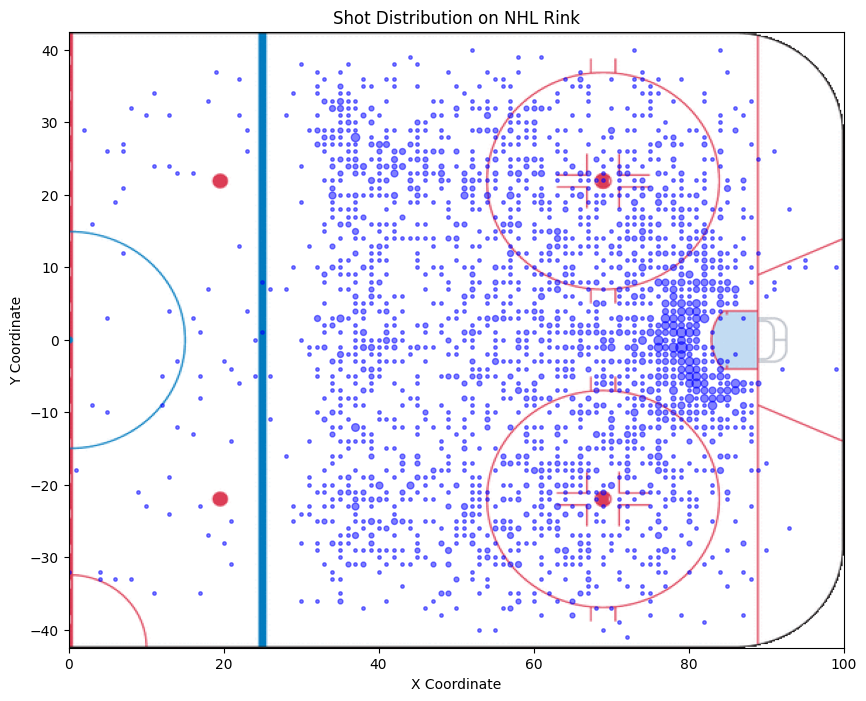

In [41]:
# Now that we have a shot map, we want to plot it

def plot_shot_map_matplotlib(shot_rate_map: pd.DataFrame):
    rink_image = mpimg.imread("../../figures/nhl_rink.png")

    plt.figure(figsize=(10, 8))
    plt.imshow(rink_image, extent=[-100, 100, -42.5, 42.5], aspect='auto')

    for _, row in tqdm(shot_rate_map.iterrows(), desc="Drawing plot"):
        x = row['x_coord']
        y = row['y_coord']
        shot_rate = row['team_shot_rate']
        plt.scatter(x, y, s=shot_rate * 500, color='blue', alpha=0.5)  # Adjust y-coordinates

    plt.xlim(0, 100)
    plt.ylim(-42.5, 42.5)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Shot Distribution on NHL Rink')

    plt.show()

plot_shot_map_matplotlib(df)

In [46]:
def plot_shot_map_plotly(shot_rate_map: pd.DataFrame):
    fig = go.Figure()

    fig.add_layout_image(
        dict(
            source=Image.open("../../figures/nhl_rink.png"),
            x=-100,
            y=42.5,
            xref="x",
            yref="y",
            sizex=200,
            sizey=85,
            opacity=1,
            sizing="stretch",
            xanchor="left",
            yanchor="top",
            layer="below"
        )
    )

    for _, row in tqdm(shot_rate_map.iterrows(), desc="Processing DataFrame"):
        fig.add_trace(go.Scatter(
            x = [row['x_coord']],
            y = [row['y_coord']],
            mode='markers',
            marker=dict(
                size = row['team_shot_rate'] * 100, 
                opacity=0.5, 
                color='blue'),
            showlegend=False
        )) 

    fig.update_layout(
        xaxis=dict(title='X Coordinate (feet)', range=[0, 100]),
        yaxis=dict(title='Y Coordinate (feet)', range=[-42.5, 42.5]),
        title='Shot Distribution on NHL Rink',
        showlegend=False,
        height=425,
        width=500,    
        plot_bgcolor='white',
        paper_bgcolor='white'
        )
    fig.show()

plot_shot_map_plotly(df)

Processing DataFrame: 0it [00:00, ?it/s]

Processing DataFrame: 1895it [00:03, 528.98it/s]


In [49]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from PIL import Image
from scipy.ndimage import gaussian_filter

def plot_shot_heatmap_plotly(shot_rate_map: pd.DataFrame):
    x = shot_rate_map['x_coord']
    y = shot_rate_map['y_coord']
    shot_rate = shot_rate_map['team_shot_rate']

    # Create a 2D histogram (heatmap) of the shot rates - obtained using ChatGPT
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=[np.linspace(0, 100, 50), np.linspace(-42.5, 42.5, 50)], weights=shot_rate)

    heatmap = gaussian_filter(heatmap, sigma=3)

    fig = go.Figure()

    fig.add_layout_image(
        dict(
            source=Image.open("../../figures/nhl_rink.png"),
            x=-100,
            y=42.5,
            xref="x",
            yref="y",
            sizex=200,
            sizey=85,
            opacity=1,
            sizing="stretch",
            xanchor="left",
            yanchor="top",
            layer="below"
        )
    )

    custom_colorscale = [[0, 'rgba(0,0,255,0)'], [0.01, 'rgba(0,0,255,0.05)'], [1, 'rgba(255,0,0,1)']]

    fig.add_trace(go.Heatmap(
        z=heatmap.T,
        x=xedges[:-1],
        y=yedges[:-1],
        colorscale=custom_colorscale,
        colorbar=dict(title='Shot Rate'),
        zmin=0,
        zmax=np.max(heatmap),
        hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Shot Density: %{z:.2f}<extra></extra>',
    ))

    fig.update_layout(
        xaxis=dict(title='X Coordinate (feet)', range=[0, 100]),
        yaxis=dict(title='Y Coordinate (feet)', range=[-42.5, 42.5]),
        title='Shot Distribution on NHL Rink',
        showlegend=False,
        height=425,
        width=500,
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    fig.show()

plot_shot_heatmap_plotly(df)